# Discrete vs Continuous Decisions: The Foundation of Integer Optimization

This notebook demonstrates the fundamental distinction between **discrete decisions** (whole numbers) and **continuous decisions** (fractional values).

Understanding this distinction is critical because:
- **Many business decisions are discrete** - you cannot hire 3.7 people or open 2.3 stores
- **Treating discrete decisions as continuous produces unrealistic recommendations**
- **The "rounding trap"** - rounding continuous solutions breaks constraints
- **Discrete decisions have fundamentally different feasible regions** - isolated points vs continuous areas


## Key Concepts

**Discrete Decisions** involve whole numbers:
- You cannot have fractional amounts
- Examples: How many people to hire, which locations to open, how many machines to buy
- You must choose from specific options: 3 or 4, not 3.5

**Continuous Decisions** involve fractional values:
- You can choose any value within a range
- Examples: Budget allocation, production volume, time spent
- You can choose 37.5% or 1,247.8 units

**The Rounding Trap**:
- Continuous models might recommend 3.7 people
- Rounding to 4 breaks the budget; rounding to 3 breaks capacity
- The model's assumptions were based on 3.7, which doesn't exist

**Critical insight**: Discrete decisions must be modeled as discrete from the start. Rounding continuous solutions creates infeasible or suboptimal recommendations.


## Scenario: Staffing Decision

You manage a call center and need to decide how many staff to schedule for the day shift.

**The Problem**:
- Each staff member costs $150 per day
- Each staff member can handle 25 calls per day
- You need to handle at least 80 calls per day
- Your budget is $600 per day

**The Decision**: How many staff members to schedule?

**The Challenge**: This is a discrete decision - you cannot schedule 3.7 people. You must schedule 3 or 4 people.

Let's see what happens when we model this as continuous vs discrete.


## Step 1: Install Required Packages (Colab)


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value

# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)


## Step 3: Define Problem Data


In [3]:
# Problem data
cost_per_staff = 150  # Cost per staff member per day ($)
calls_per_staff = 25  # Calls each staff member can handle
min_calls_needed = 80  # Minimum calls that must be handled
budget = 600  # Maximum budget per day ($)

print("PROBLEM DATA:")
print(f"  Cost per staff: ${cost_per_staff}")
print(f"  Calls per staff: {calls_per_staff}")
print(f"  Minimum calls needed: {min_calls_needed}")
print(f"  Budget limit: ${budget}")


PROBLEM DATA:
  Cost per staff: $150
  Calls per staff: 25
  Minimum calls needed: 80
  Budget limit: $600


## Step 4: Model as Continuous (The Wrong Way)

First, let's model this as a continuous problem - treating staff as if we could have fractional amounts:


In [4]:
# Continuous model (WRONG for this problem, but commonly done)
model_continuous = LpProblem("Staffing_Continuous", LpMinimize)

# Continuous variable (can be fractional)
staff_continuous = LpVariable("staff_continuous", lowBound=0, cat='Continuous')

# Objective: Minimize cost
model_continuous += cost_per_staff * staff_continuous, "Total_Cost"

# Constraints
model_continuous += calls_per_staff * staff_continuous >= min_calls_needed, "Min_Calls"
model_continuous += cost_per_staff * staff_continuous <= budget, "Budget"

# Solve
model_continuous.solve()

# Get solution
staff_continuous_solution = value(staff_continuous)
total_cost_continuous = value(model_continuous.objective)
calls_handled_continuous = calls_per_staff * staff_continuous_solution

print("CONTINUOUS MODEL SOLUTION:")
print(f"  Staff to schedule: {staff_continuous_solution:.2f} people")
print(f"  Total cost: ${total_cost_continuous:.2f}")
print(f"  Calls handled: {calls_handled_continuous:.2f}")
print(f"\n⚠️  PROBLEM: You cannot schedule {staff_continuous_solution:.2f} people!")
print("   This recommendation is impossible to implement.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/de175b7b1b6d4329be4c44b97b295634-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/de175b7b1b6d4329be4c44b97b295634-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 11 RHS
At line 14 BOUNDS
At line 15 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-2) rows, 0 (-1) columns and 0 (-2) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 480
After Postsolve, objective 480, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 480 - 0 iterations time 0.002, Presolve 0.00
Option for printingOpt

## Step 5: The Rounding Trap

What happens if we try to round the continuous solution? Let's see:


In [5]:
# Try rounding down
staff_rounded_down = int(staff_continuous_solution)
cost_down = cost_per_staff * staff_rounded_down
calls_down = calls_per_staff * staff_rounded_down

# Try rounding up
staff_rounded_up = int(staff_continuous_solution) + 1
cost_up = cost_per_staff * staff_rounded_up
calls_up = calls_per_staff * staff_rounded_up

# Check feasibility
feasible_down = (calls_down >= min_calls_needed) and (cost_down <= budget)
feasible_up = (calls_up >= min_calls_needed) and (cost_up <= budget)

print("THE ROUNDING TRAP:")
print("=" * 60)
print(f"\nContinuous solution: {staff_continuous_solution:.2f} people")
print(f"\nOption 1: Round DOWN to {staff_rounded_down} people")
print(f"  Cost: ${cost_down} (within budget: {cost_down <= budget})")
print(f"  Calls handled: {calls_down} (meets requirement: {calls_down >= min_calls_needed})")
print(f"  Feasible: {'✓ YES' if feasible_down else '✗ NO'}")

print(f"\nOption 2: Round UP to {staff_rounded_up} people")
print(f"  Cost: ${cost_up} (within budget: {cost_up <= budget})")
print(f"  Calls handled: {calls_up} (meets requirement: {calls_up >= min_calls_needed})")
print(f"  Feasible: {'✓ YES' if feasible_up else '✗ NO'}")

if not feasible_down and not feasible_up:
    print("\n⚠️  BOTH ROUNDED SOLUTIONS ARE PROBLEMATIC!")
    print("   The continuous model's assumptions don't hold for whole numbers.")
elif not feasible_down:
    print("\n⚠️  Rounding down breaks constraints!")
elif not feasible_up:
    print("\n⚠️  Rounding up breaks constraints!")


THE ROUNDING TRAP:

Continuous solution: 3.20 people

Option 1: Round DOWN to 3 people
  Cost: $450 (within budget: True)
  Calls handled: 75 (meets requirement: False)
  Feasible: ✗ NO

Option 2: Round UP to 4 people
  Cost: $600 (within budget: True)
  Calls handled: 100 (meets requirement: True)
  Feasible: ✓ YES

⚠️  Rounding down breaks constraints!


## Step 6: Model as Discrete (The Correct Way)

Now let's model this correctly as a discrete problem:


In [6]:
# Discrete model (CORRECT for this problem)
model_discrete = LpProblem("Staffing_Discrete", LpMinimize)

# Integer variable (must be whole number)
staff_discrete = LpVariable("staff_discrete", lowBound=0, cat='Integer')

# Objective: Minimize cost
model_discrete += cost_per_staff * staff_discrete, "Total_Cost"

# Constraints
model_discrete += calls_per_staff * staff_discrete >= min_calls_needed, "Min_Calls"
model_discrete += cost_per_staff * staff_discrete <= budget, "Budget"

# Solve
model_discrete.solve()

# Get solution
staff_discrete_solution = int(value(staff_discrete))
total_cost_discrete = value(model_discrete.objective)
calls_handled_discrete = calls_per_staff * staff_discrete_solution

print("DISCRETE MODEL SOLUTION:")
print(f"  Staff to schedule: {staff_discrete_solution} people")
print(f"  Total cost: ${total_cost_discrete:.2f}")
print(f"  Calls handled: {calls_handled_discrete}")
print(f"\n✓ This solution can actually be implemented!")
print(f"  It meets all constraints and is a whole number.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/28dfff53e0ad40ff86bb1b60f85f5341-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/28dfff53e0ad40ff86bb1b60f85f5341-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 480 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 600 to -1.79769e+308
Probing was tried 0 times and created 0 cuts 

## Step 7: Visual Comparison

Let's visualize the difference between continuous and discrete solutions:


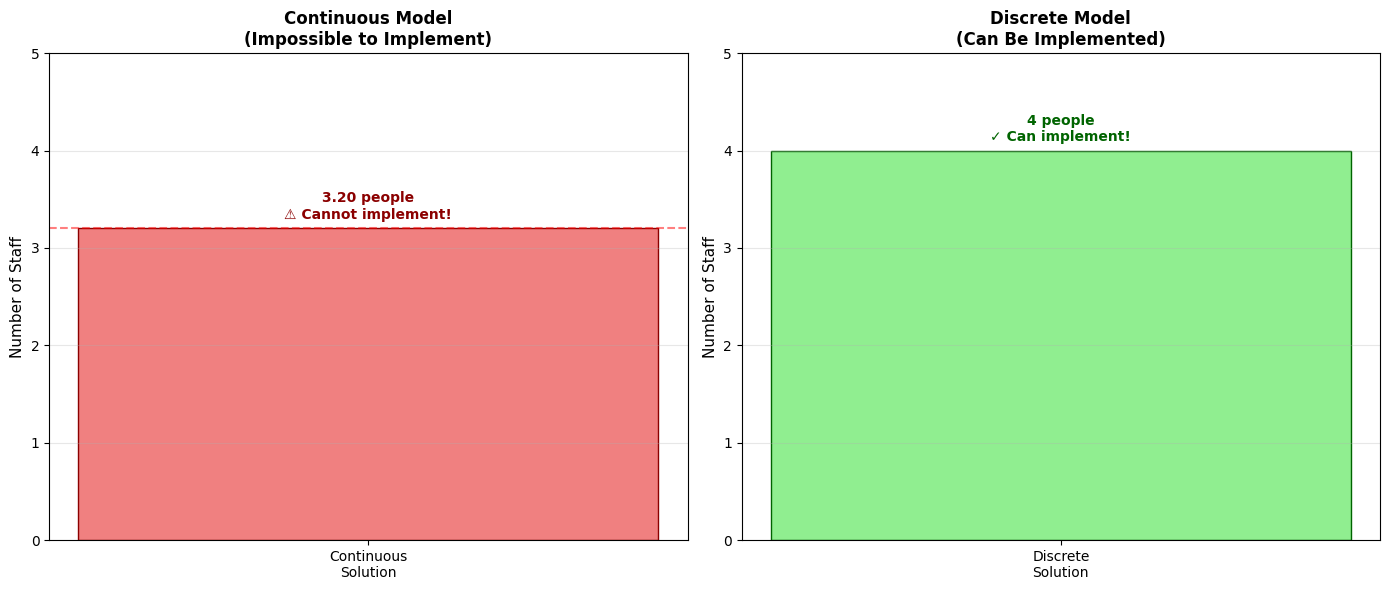


COMPARISON:


,Model Type,Staff Recommended,Can Implement?,Total Cost,Calls Handled
0,Continuous,3.20,✗ NO (fractional),$480.00,80
1,Discrete,4,✓ YES (whole number),$600.00,100


In [7]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Continuous solution
ax1.bar(['Continuous\nSolution'], [staff_continuous_solution], 
        color='lightcoral', edgecolor='darkred', width=0.5)
ax1.axhline(y=staff_continuous_solution, color='red', linestyle='--', alpha=0.5, label=f'{staff_continuous_solution:.2f}')
ax1.set_ylabel('Number of Staff', fontsize=11)
ax1.set_title('Continuous Model\n(Impossible to Implement)', fontweight='bold', fontsize=12)
ax1.set_ylim(0, max(staff_continuous_solution, staff_discrete_solution) + 1)
ax1.grid(axis='y', alpha=0.3)
ax1.text(0, staff_continuous_solution + 0.1, f'{staff_continuous_solution:.2f} people\n⚠️ Cannot implement!', 
         ha='center', fontsize=10, color='darkred', fontweight='bold')

# Right plot: Discrete solution
ax2.bar(['Discrete\nSolution'], [staff_discrete_solution], 
        color='lightgreen', edgecolor='darkgreen', width=0.5)
ax2.set_ylabel('Number of Staff', fontsize=11)
ax2.set_title('Discrete Model\n(Can Be Implemented)', fontweight='bold', fontsize=12)
ax2.set_ylim(0, max(staff_continuous_solution, staff_discrete_solution) + 1)
ax2.grid(axis='y', alpha=0.3)
ax2.text(0, staff_discrete_solution + 0.1, f'{staff_discrete_solution} people\n✓ Can implement!', 
         ha='center', fontsize=10, color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.show()

# Create comparison table
comparison = pd.DataFrame({
    'Model Type': ['Continuous', 'Discrete'],
    'Staff Recommended': [f'{staff_continuous_solution:.2f}', f'{staff_discrete_solution}'],
    'Can Implement?': ['✗ NO (fractional)', '✓ YES (whole number)'],
    'Total Cost': [f'${total_cost_continuous:.2f}', f'${total_cost_discrete:.2f}'],
    'Calls Handled': [f'{calls_handled_continuous:.0f}', f'{calls_handled_discrete}']
})

print("\nCOMPARISON:")
print("=" * 70)
display(comparison)


## Step 8: Visualize Feasible Regions

Let's visualize why discrete decisions have different feasible regions:


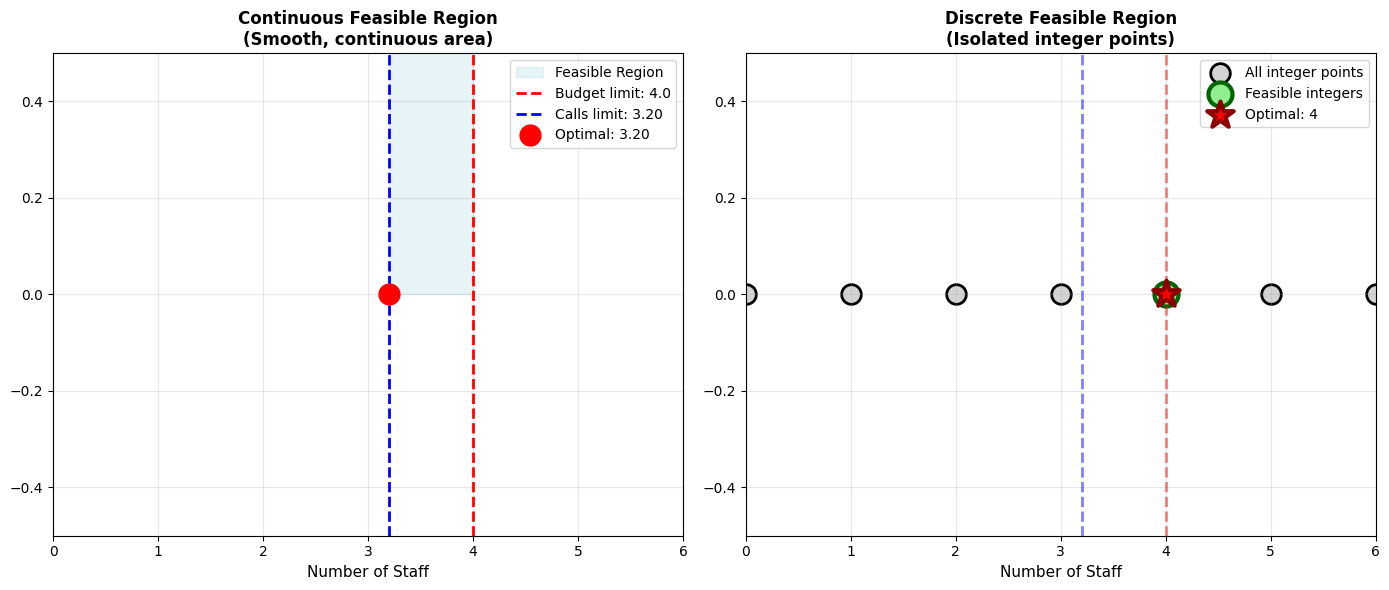


Key Observation:
  Continuous: Feasible region is a continuous interval [3.20, 4.0]
  Discrete: Feasible points are only at integers: [np.int64(4)]
  Discrete feasible region is much smaller!


In [8]:
# Create feasible region visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Calculate constraint boundaries
max_staff = 6
staff_range = np.linspace(0, max_staff, 1000)

# Budget constraint: cost <= 600, so staff <= 600/150 = 4
budget_limit = budget / cost_per_staff

# Calls constraint: calls >= 80, so staff >= 80/25 = 3.2
calls_limit = min_calls_needed / calls_per_staff

# Left plot: Continuous feasible region
ax1.fill_between([calls_limit, budget_limit], [0, 0], [10, 10], 
                  alpha=0.3, color='lightblue', label='Feasible Region')
ax1.axvline(x=budget_limit, color='red', linestyle='--', linewidth=2, label=f'Budget limit: {budget_limit:.1f}')
ax1.axvline(x=calls_limit, color='blue', linestyle='--', linewidth=2, label=f'Calls limit: {calls_limit:.2f}')
ax1.plot([staff_continuous_solution], [0], 'ro', markersize=15, label=f'Optimal: {staff_continuous_solution:.2f}')
ax1.set_xlabel('Number of Staff', fontsize=11)
ax1.set_ylabel('', fontsize=11)
ax1.set_title('Continuous Feasible Region\n(Smooth, continuous area)', fontweight='bold', fontsize=12)
ax1.set_xlim(0, max_staff)
ax1.set_ylim(-0.5, 0.5)
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# Right plot: Discrete feasible points
discrete_staff = np.arange(0, max_staff + 1)
feasible_discrete = []
for s in discrete_staff:
    cost = cost_per_staff * s
    calls = calls_per_staff * s
    if calls >= min_calls_needed and cost <= budget:
        feasible_discrete.append(s)

ax2.scatter(discrete_staff, [0]*len(discrete_staff), s=200, c='lightgray', 
            edgecolors='black', linewidths=2, label='All integer points', zorder=1)
ax2.scatter(feasible_discrete, [0]*len(feasible_discrete), s=300, c='lightgreen', 
            edgecolors='darkgreen', linewidths=3, label='Feasible integers', zorder=2)
if staff_discrete_solution in feasible_discrete:
    ax2.scatter([staff_discrete_solution], [0], s=400, c='red', 
                edgecolors='darkred', linewidths=3, marker='*', label=f'Optimal: {staff_discrete_solution}', zorder=3)
ax2.axvline(x=budget_limit, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax2.axvline(x=calls_limit, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Number of Staff', fontsize=11)
ax2.set_ylabel('', fontsize=11)
ax2.set_title('Discrete Feasible Region\n(Isolated integer points)', fontweight='bold', fontsize=12)
ax2.set_xlim(0, max_staff)
ax2.set_ylim(-0.5, 0.5)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Observation:")
print(f"  Continuous: Feasible region is a continuous interval [{calls_limit:.2f}, {budget_limit:.1f}]")
print(f"  Discrete: Feasible points are only at integers: {feasible_discrete}")
print(f"  Discrete feasible region is much smaller!")


## Step 9: Explore Different Scenarios

Let's see how the solutions differ across different scenarios:


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/73bf9f5e1c93418aaaa89af0dd81829b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/73bf9f5e1c93418aaaa89af0dd81829b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 11 RHS
At line 14 BOUNDS
At line 15 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 3.1999999 (1)
Primal infeasible - objective value 480
PrimalInfeasible objective 480 - 1 iterations time 0.002

Result - Linear relaxation infeasible



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/026b874016534d7a959283e694b86fa2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/026b874016534d7a959283e694b86fa2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/p

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1ccf907aee8a416f8e9c5fd9cb02d776-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1ccf907aee8a416f8e9c5fd9cb02d776-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 11 RHS
At line 14 BOUNDS
At line 15 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-2) rows, 0 (-1) columns and 0 (-2) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 480
After Postsolve, objective 480, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 480 - 0 iterations time 0.002, Presolve 0.00
Option for printingOpt

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/f4ce9530d67148c792302ef447639ec1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/f4ce9530d67148c792302ef447639ec1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 480 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 600 to -1.79769e+308
Probing was tried 0 times and created 0 cuts 

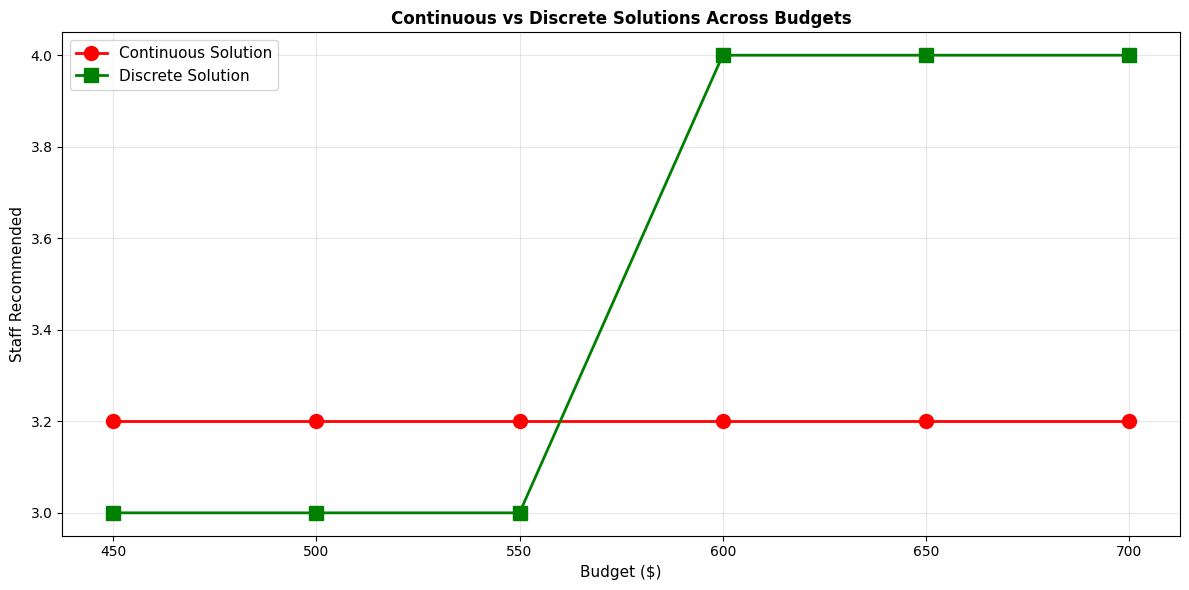


SCENARIO COMPARISON:


,Budget,Continuous,Discrete,Difference
0,450,3.2,3,0.2
1,500,3.2,3,0.2
2,550,3.2,3,0.2
3,600,3.2,4,0.8
4,650,3.2,4,0.8
5,700,3.2,4,0.8



Key Insight:
  • Continuous solutions are smooth (can be any value)
  • Discrete solutions are stepped (only whole numbers)
  • The difference varies - sometimes small, sometimes large
  • But discrete solutions are always implementable!


In [9]:
# Test different budget scenarios
budgets = [450, 500, 550, 600, 650, 700]
results = []

for b in budgets:
    # Continuous model
    m_cont = LpProblem("Continuous", LpMinimize)
    s_cont = LpVariable("staff", lowBound=0, cat='Continuous')
    m_cont += cost_per_staff * s_cont
    m_cont += calls_per_staff * s_cont >= min_calls_needed
    m_cont += cost_per_staff * s_cont <= b
    m_cont.solve()
    sol_cont = value(s_cont)
    
    # Discrete model
    m_disc = LpProblem("Discrete", LpMinimize)
    s_disc = LpVariable("staff", lowBound=0, cat='Integer')
    m_disc += cost_per_staff * s_disc
    m_disc += calls_per_staff * s_disc >= min_calls_needed
    m_disc += cost_per_staff * s_disc <= b
    m_disc.solve()
    sol_disc = int(value(s_disc))
    
    results.append({
        'Budget': b,
        'Continuous': sol_cont,
        'Discrete': sol_disc,
        'Difference': abs(sol_cont - sol_disc)
    })

results_df = pd.DataFrame(results)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_df['Budget'], results_df['Continuous'], 'o-', 
        label='Continuous Solution', linewidth=2, markersize=10, color='red')
ax.plot(results_df['Budget'], results_df['Discrete'], 's-', 
        label='Discrete Solution', linewidth=2, markersize=10, color='green')
ax.set_xlabel('Budget ($)', fontsize=11)
ax.set_ylabel('Staff Recommended', fontsize=11)
ax.set_title('Continuous vs Discrete Solutions Across Budgets', fontweight='bold', fontsize=12)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xticks(results_df['Budget'])

plt.tight_layout()
plt.show()

print("\nSCENARIO COMPARISON:")
print("=" * 70)
display(results_df)

print("\nKey Insight:")
print("  • Continuous solutions are smooth (can be any value)")
print("  • Discrete solutions are stepped (only whole numbers)")
print("  • The difference varies - sometimes small, sometimes large")
print("  • But discrete solutions are always implementable!")


## Summary: Discrete vs Continuous Decisions

**Discrete Decisions**:
- Involve whole numbers: people, machines, locations
- Must be modeled with integer constraints
- Have isolated feasible points, not continuous regions
- Solutions are always implementable

**Continuous Decisions**:
- Can involve fractional values: budgets, time, volumes
- Modeled without integer constraints
- Have smooth, continuous feasible regions
- Solutions may need rounding (which can break constraints)

**The Rounding Trap**:
- Continuous models for discrete problems produce fractional recommendations
- Rounding these recommendations breaks the model's assumptions
- Constraints may be violated after rounding
- The solution becomes infeasible or suboptimal

**Critical Takeaway**:
- **If a decision is discrete, model it as discrete from the start**
- Don't round continuous solutions - build integer models instead
- Discrete models produce implementable recommendations
- Understanding this distinction is the foundation of realistic optimization
